In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os

from code.data_prep import PenisData
from code.desiCNN import DesiCNN
import code.lasses as ls

torch.set_default_tensor_type('torch.FloatTensor')
# set up default cuda device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
train_ape = PenisData(root_path="./dataset/", mode="train", label="ape")
train_benchvise = PenisData(root_path="./dataset/", mode="train", label="benchvise")
train_cam = PenisData(root_path="./dataset/", mode="train", label="cam")
train_cat = PenisData(root_path="./dataset/", mode="train", label="cat")
train_duck = PenisData(root_path="./dataset/", mode="train", label="duck")

print(len(train_ape))

1482


### Batch generator

In [12]:
def batch_generator(batch_size=10):
    classes = ["ape", "benchvise", "cam", "cat", "duck"]
    
    batches_img = []
    batches_pose = []
    
    for i in range(batch_size):
        rand_classes = np.random.randint(1, 5)
        rand_img = np.random.randint(0, 1482)
        best_similarity = 100
        anchor, anchor_pose = PenisData(root_path="./dataset/", mode="train", label=classes[rand_classes])[rand_img]
        rand_push_class = np.random.randint(1, 5)
        # Random image is not random
        # anchor and pusher pose different but maybe not pusher and puller pose
        pusher, pusher_pose = PenisData(root_path="./dataset/", mode="train", label=classes[rand_push_class])[rand_img-2]
        
        db = PenisData(root_path="./dataset/", mode="database", label=classes[rand_classes])
        puller, puller_pose = db[0]
        # No idea if this works
        for p in range(len(db)):
            current, current_pose = db[p]
            # Old quaternion similarity measure
            similarity = 2. * np.arccos(abs(np.dot(anchor_pose, current_pose)))

            # # New quaternion similarity measure
            # similarity = 2. * np.arccos(np.dot(anchor_pose, current_pose)**2 - 1)
            
            # Similarity but for some reason we're reducing it?
            # Don't ask why
            if similarity < best_similarity:
                best_similarity = similarity
                puller, puller_pose = current, current_pose
        
        # One batch is list of anchor, puller, pusher
        batch = [anchor, puller, pusher]
        batch_pose = [anchor_pose, puller_pose, pusher_pose]
        
        batches_img.append(batch)
        batches_pose.append(batch_pose)
        print("Best similarity: ", best_similarity)
    return np.array(batches_img), np.array(batches_pose)

### Visualize batches

Best similarity:  0.1383935850269516
Best similarity:  0.17713614142347045
Best similarity:  0.14547764806899985
Best similarity:  0.17032604491320186
Best similarity:  0.1824566411222788
Best similarity:  0.10006335799231705
Best similarity:  0.1595559192945911
Best similarity:  0.2428722187567875
Best similarity:  0.14562364114101595
Best similarity:  0.14260891052708588


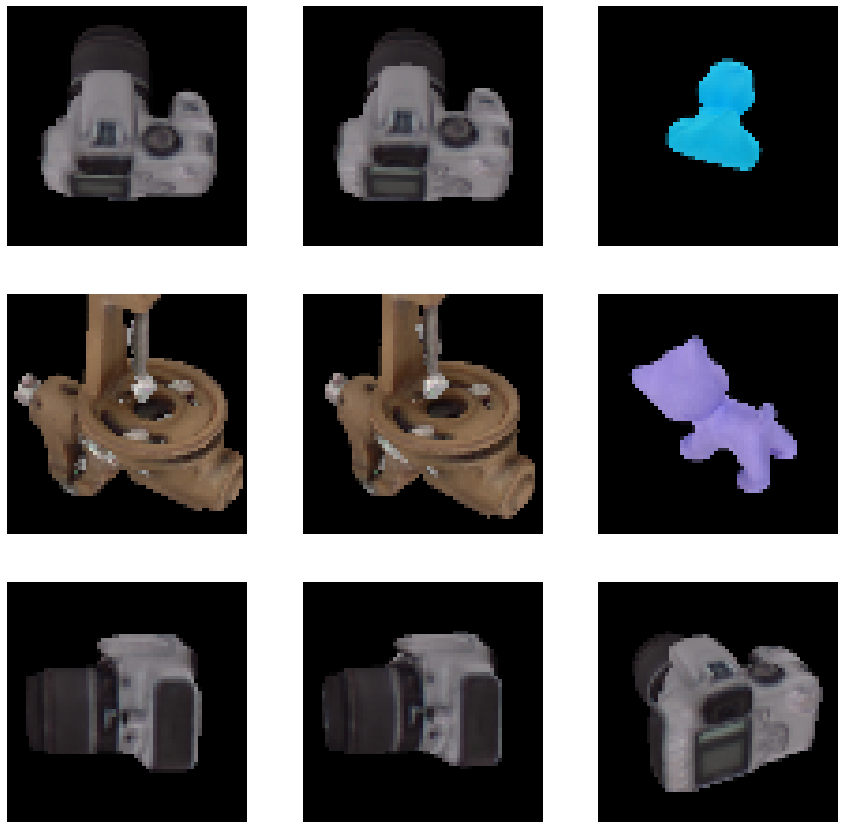

In [13]:
batches_img, batches_pose = batch_generator(batch_size=10)
num_example = 3

plt.figure(figsize=(15, 5 * num_example))
for i in range(num_example):
    plt.subplot(num_example, 3, i*3+1)
    plt.imshow(batches_img[i, 0])
    plt.axis("off")
    
    plt.subplot(num_example, 3, i*3+2)
    plt.imshow(batches_img[i, 1])
    plt.axis("off")

    plt.subplot(num_example, 3, i*3+3)
    plt.imshow(batches_img[i, 2])
    plt.axis("off")

In [4]:
model = DesiCNN()
optim_args = {"lr": 1e-3, "weight_decay": 0.001}
optim = torch.optim.Adam(model.parameters(), **optim_args)

model.to(device)
model.train()

batch_size = 1000
batches_img, batches_pose = batch_generator(batch_size=batch_size)
epochs = 20

print("START TRAIN")

for i in range(epochs):
    print("Epoch: ", i)
    inputs = batches_img[i*int(batch_size/epochs):i*int(batch_size/epochs) + int(batch_size/epochs)]
    inputs = torch.from_numpy(inputs).to(device, dtype=torch.float)
    inputs = inputs.transpose(2, 4)
    inputs = inputs.transpose(3, 4)
    outputs_a = model(inputs[:, 0])
    outputs_pull = model(inputs[:, 1])
    outputs_push = model(inputs[:, 2])
    
    loss = ls.total_loss(outputs_a, outputs_push, outputs_pull)
    loss.backward()
    optim.step()
    
    print("Loss: ", loss.detach().cpu().numpy())
    

/home/dhaval/anaconda3/envs/tdcv/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in arccos


START TRAIN
Epoch:  0
Loss:  3986.4194
Epoch:  1
Loss:  2611.7993
Epoch:  2
Loss:  1017.3051
Epoch:  3
Loss:  355.51932
Epoch:  4
Loss:  141.08171
Epoch:  5
Loss:  93.7564
Epoch:  6
Loss:  35.550198
Epoch:  7
Loss:  23.63625
Epoch:  8
Loss:  17.230911
Epoch:  9
Loss:  9.010133
Epoch:  10
Loss:  7.494957
Epoch:  11
Loss:  7.301839
Epoch:  12
Loss:  6.290447
Epoch:  13
Loss:  6.3112383
Epoch:  14
Loss:  5.000604
Epoch:  15
Loss:  5.3265676
Epoch:  16
Loss:  1.5269334
Epoch:  17
Loss:  6.56046
Epoch:  18
Loss:  5.4221272
Epoch:  19
Loss:  6.362016
Epoch:  20
Loss:  5.2518706
Epoch:  21
Loss:  6.108657
Epoch:  22
Loss:  5.870264
Epoch:  23
Loss:  7.6350045
Epoch:  24
Loss:  5.575869
Epoch:  25
Loss:  7.589978
Epoch:  26
Loss:  9.216527
Epoch:  27
Loss:  6.804557
Epoch:  28
Loss:  6.896566
Epoch:  29
Loss:  6.7314577
Epoch:  30
Loss:  6.0457773
Epoch:  31
Loss:  6.605463
Epoch:  32
Loss:  7.095147
Epoch:  33
Loss:  7.8858843
Epoch:  34
Loss:  8.250441
Epoch:  35
Loss:  6.89887
Epoch:  36
Lo